## CarND-Vehicle-Detection
This is a implement of CarND-Vehicle-Detection in Udacity. Here I will use the methods in program as teachers told. The progress will contain the following list:

* The color features: will use the histograms of color to produce a classifier for car detection
* The Histogram of Oriented Gradients (HOG) feature: extract on images and train a Linear SVM classifier.
* The sliding-window: the method which is used for search the cars with the trained model
* The heatmap and labelizaion: those which is used for handling the Multiple Detections and False Positives

Now I will complete those steps one by one.

## Step 0: Import Needed Library and Data

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import pickle
import glob
import time
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label
from collections import deque
from sklearn.utils import shuffle
from sklearn.svm import LinearSVC
from skimage.feature import hog
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

In [2]:
# Read in car and non-car images
cars = glob.glob('../data/vehicles/*/*.png')
notcars = glob.glob('../data/non-vehicles/*/*.png')

## Step 1: Color Features
The different object has different size of colors or different value of colors. Sometimes we can identify the object through the their special colors. 

Here we compute the histograms of color in given image

In [2]:
# Define a function to compute color histogram features  
def rgb_color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(image[:,:,0], bins=32, range=(0, 256))
    ghist = np.histogram(image[:,:,1], bins=32, range=(0, 256))
    bhist = np.histogram(image[:,:,2], bins=32, range=(0, 256))
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

Now let us see the histograms of RGB color in given imgae

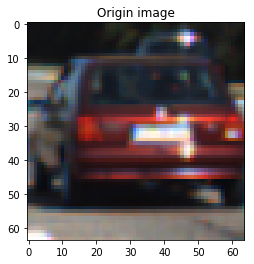

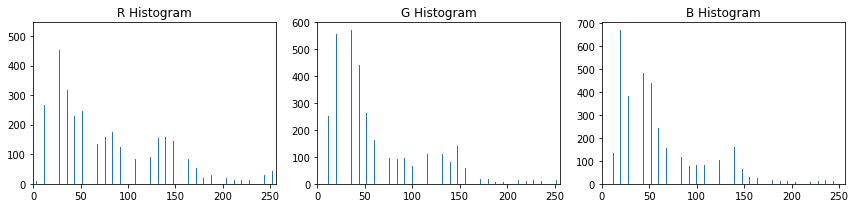

In [4]:
image = mpimg.imread('./other_images/cutout2.jpg')
rh, gh, bh, bincen, feature_vec = rgb_color_hist(image, nbins=32, bins_range=(0, 256))

# Plot a figure with all three bar charts
if rh is not None:
    plt.imshow(image)
    plt.title('Origin image')
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()
else:
    print('Your function is returning None for at least one variable...')

We can look at different color histogram on different images. Otherwise, for different color space we get the different histogram of color. Now I will define a function for different color space.

In [2]:
def color_hist(img, nbins=32, bins_range=(0, 256)):
    first_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    second_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    third_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Generating bin centers
    bin_edges = first_hist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((first_hist[0], second_hist[0], third_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return first_hist, second_hist, third_hist, bin_centers, hist_features

Sometimes, the different resolution of image doesn't matter for object detection. For feature of object, we can detecte from different resolution image. So we can decrease the resolution of image for low compute.

In [3]:
def bin_spatial(img, size=(32, 32)):
    small_img = cv2.resize(img, size)
    features = small_img.ravel()
    # Return the feature vector
    return features

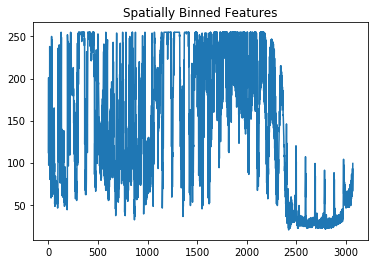

In [17]:
image = mpimg.imread('./other_images/cutout1.jpg')
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot features
plt.plot(feature_vec)
plt.title('Spatially Binned Features')

## Step 2: HOG Features
The hog function is to extract Histogram of Oriented Gradient features for image. We can refer it from [scikit-image](http://scikit-image.org/) package.

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        # Use skimage.hog() to get both features and a visualization
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, transform_sqrt=True, feature_vector=feature_vec)
        return features, hog_image
    else:      
        # Use skimage.hog() to get features only
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell), cells_per_block=(cell_per_block, cell_per_block), visualise=vis, transform_sqrt=True, feature_vector=feature_vec)
        return features

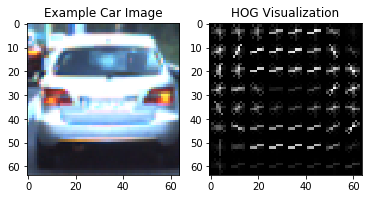

In [21]:
# Read in the image
image = mpimg.imread('./other_images/cutout1.jpg')
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2
# Call our function with vis=True to see an image output
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(image, cmap='gray')
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(hog_image, cmap='gray')
plt.title('HOG Visualization')

## Step 3: Features Combination
The combination is a usual method for multi features in same image. Here we will combine the color feature and bin spatial feature in same image.

But one important point is that normalize the output feature. 

In [48]:
def extract_features(img, color_space='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256)):
    # Convert image to new color space (if specified)
    if 'HSV' == color_space:
        color_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif 'LUV' == color_space:
        color_img = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif 'HLS' == color_space:
        color_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif 'YUV' == color_space:
        color_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif 'YCrCb' == color_space:
        color_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        color_img = np.copy(img)
    bin_feature = bin_spatial(color_img, spatial_size)
    _, _, _, _, hist_feature = color_hist(color_img, hist_bins, hist_range)
    feature = np.concatenate((bin_feature, hist_feature))
    return feature

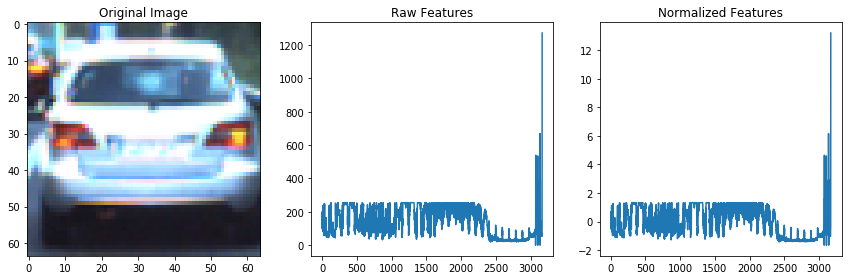

In [26]:
# Read in the image
image = mpimg.imread('./other_images/cutout1.jpg')
features = extract_features(image, color_space='RGB', spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256))

# Fit a per-column scaler
X = np.vstack(features).astype(np.float64)    
X_scaler = StandardScaler().fit(X)
scaled_X = X_scaler.transform(X)
fig = plt.figure(figsize=(12,4))
plt.subplot(131)
plt.imshow(image)
plt.title('Original Image')
plt.subplot(132)
plt.plot(features)
plt.title('Raw Features')
plt.subplot(133)
plt.plot(scaled_X)
plt.title('Normalized Features')
fig.tight_layout()

## Step 4: Slide Window
For searching car object, we should slide search window on image. Here we define a funtion for sliding search window.

In [5]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    window_list = []
    # Loop through finding x and y window positions
    #     Note: you could vectorize this step, but in practice
    #     you'll be considering windows one by one with your
    #     classifier, so looping makes sense
        # Calculate each window position
        # Append window position to list
    # Return the list of windows
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    slide_end_y = y_start_stop[0] + xy_window[1]
    slide_x_step = np.int(xy_overlap[0] * xy_window[0])
    slide_y_step = np.int(xy_overlap[1] * xy_window[1])
    while slide_end_y <= y_start_stop[1]:
        slide_end_x = x_start_stop[0] + xy_window[0]
        while slide_end_x <= x_start_stop[1]:
            window_list.append(((slide_end_x - xy_window[0], slide_end_y - xy_window[1]), (slide_end_x, slide_end_y)))
            slide_end_x += slide_x_step
        slide_end_y += slide_y_step
    return window_list

We should take a look at the effecient of slide window on image. Here we defined the draw function like below:

In [6]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

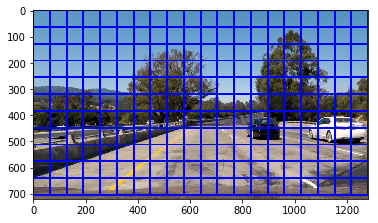

In [29]:
image = mpimg.imread('./test_images/test1.jpg')
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(128, 128), xy_overlap=(0.5, 0.5))
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=6)                    
plt.imshow(window_img)

## Step 5: Classifier Making
Here we will define a classifier to train a model for car detection. We will use the function LinearSVC in SVM library to train model.

In [40]:
# performs under different binning scenarios
spatial = 32
histbin = 46

car_features = []
notcar_features = []
for car_image in cars:
    image = mpimg.imread(car_image)
    car_features.append(extract_features(image, color_space='RGB', spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256)))
for notcar_image in notcars:
    image = mpimg.imread(notcar_image)
    notcar_features.append(extract_features(image, color_space='RGB', spatial_size=(spatial, spatial), hist_bins=histbin, hist_range=(0, 256)))

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using spatial binning of:',spatial,
    'and', histbin,'histogram bins')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=1.0)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using spatial binning of: 32 and 46 histogram bins
Feature vector length: 3168
46.81 Seconds to train SVC...
Test Accuracy of SVC =  0.915
My SVC predicts:  [ 0.  0.  1.  0.  0.  0.  0.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  1.  0.  0.  0.  1.  1.  0.  1.]
0.00131 Seconds to predict 10 labels with SVC


We achieve the classifier for color feature, for hog feature we can also achieve the classifier like below:

In [44]:
def extract_hog_features(img, color_space='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Convert image to new color space (if specified)
    if 'HSV' == color_space:
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif 'LUV' == color_space:
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif 'HLS' == color_space:
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif 'YUV' == color_space:
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif 'YCrCb' == color_space:
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    if hog_channel == 'ALL':
        hog_features = []
        for channel in range(feature_image.shape[2]):
            hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
        hog_features = np.ravel(hog_features)        
    else:
        hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)

    return hog_features

In [45]:
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

t=time.time()
car_features = []
notcar_features = []
for car_image in cars:
    image = mpimg.imread(car_image)
    car_features.append(extract_hog_features(image, color_space=colorspace, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))
for notcar_image in notcars:
    image = mpimg.imread(notcar_image)
    notcar_features.append(extract_hog_features(image, color_space=colorspace, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel))

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))


# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=1.0)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

67.8 Seconds to extract HOG features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 5292
13.94 Seconds to train SVC...
Test Accuracy of SVC =  0.9814
My SVC predicts:  [ 0.  0.  1.  1.  0.  1.  1.  0.  1.  0.]
For these 10 labels:  [ 0.  0.  1.  1.  0.  1.  1.  0.  1.  1.]
0.00127 Seconds to predict 10 labels with SVC


So we define the classifier for color feature and hog feature speratly. And the effect is not bad. We will define a function which combine the color feature and hog feature together for later classifier.

In [7]:
# Define a function to extract needed features from a image
# This function is very similar to extract_features and extract_hog_features
def combine_img_features(img, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):    
    #1) Define an empty list to receive features
    img_features = []
    #2) Apply color conversion if other than 'RGB'
    if 'HSV' == color_space:
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    elif 'LUV' == color_space:
        feature_image = cv2.cvtColor(img, cv2.COLOR_BGR2LUV)
    elif 'HLS' == color_space:
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    elif 'YUV' == color_space:
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    elif 'YCrCb' == color_space:
        feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else:
        feature_image = np.copy(img)
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        _, _, _, _, hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)

    #9) Return concatenated array of features
    return np.concatenate(img_features)

Now we will define the classifier base on the combined feature.

In [30]:
# define the params for getting feature
spatial = 16
histbin = 32
colorspace = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9
pix_per_cell = 8
cell_per_block = 2
hog_channel = "ALL" # Can be 0, 1, 2, or "ALL"

In [10]:
t=time.time()
car_features = []
notcar_features = []
for car_image in cars:
    image = mpimg.imread(car_image)
    car_features.append(combine_img_features(image, color_space=colorspace, spatial_size=(spatial, spatial), hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=True, hist_feat=True, hog_feat=True))
for notcar_image in notcars:
    image = mpimg.imread(notcar_image)
    notcar_features.append(combine_img_features(image, color_space=colorspace, spatial_size=(spatial, spatial), hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=True, hist_feat=True, hog_feat=True))

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract combined features...')

86.12 Seconds to extract combined features...


In [11]:
# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

In [12]:
car_total_num = len(car_features)
notcar_total_num = len(notcar_features)
print(car_total_num, " car feature")
print(notcar_total_num, " notcar feature")

8792  car feature
8968  notcar feature


In [13]:
# Define the labels vector
y = np.hstack((np.ones(car_total_num), np.zeros(notcar_total_num)))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
car_x_train, car_x_test, car_y_train, car_y_test = train_test_split(
    scaled_X[:car_total_num], y[:car_total_num], test_size=0.2, random_state=rand_state)
notcar_x_train, notcar_x_test, notcar_y_train, notcar_y_test = train_test_split(
    scaled_X[car_total_num:], y[car_total_num:], test_size=0.2, random_state=rand_state)

X_train = np.vstack((car_x_train, notcar_x_train))
X_test = np.vstack((car_x_test, notcar_x_test))
y_train = np.hstack((car_y_train, notcar_y_train))
y_test = np.hstack((car_y_test, notcar_y_test))

In [14]:
X_train,y_train = shuffle(X_train,y_train,random_state=42)
X_test,y_test = shuffle(X_test,y_test,random_state=42)

In [15]:
print('apply the color and hog combined features:')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC(C=1.0)
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 50
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

apply the color and hog combined features:
Feature vector length: 6156
17.33 Seconds to train SVC...
Test Accuracy of SVC =  0.9887
My SVC predicts:  [ 1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.
  0.  1.  0.  1.  0.  1.  0.  0.  1.  1.  0.  0.  0.  1.  0.  1.  0.  1.
  1.  1.  1.  0.  0.  0.  0.  1.  1.  1.  1.  1.  0.  1.]
For these 50 labels:  [ 1.  0.  0.  1.  0.  1.  0.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  0.
  0.  1.  0.  1.  0.  1.  0.  1.  1.  1.  0.  0.  0.  1.  0.  1.  0.  1.
  1.  1.  1.  0.  0.  0.  0.  1.  1.  1.  1.  1.  0.  1.]
0.00291 Seconds to predict 50 labels with SVC


In [16]:
test_pro_imgs = glob.glob('./cache/*.png')
test_pro_features = []
for test_pro_image in test_pro_imgs:
    image = mpimg.imread(test_pro_image)
    test_pro_features.append(combine_img_features(image, color_space=colorspace, spatial_size=(spatial, spatial), hist_bins=histbin, orient=orient, pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel, spatial_feat=True, hist_feat=True, hog_feat=True))

result_feat = X_scaler.transform(test_pro_features)

print('My SVC predicts: ', svc.predict(result_feat))

My SVC predicts:  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  1.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]


We get the 0.9887 accuracy for detect car image.

In [17]:
# Save the data for easy access
pickle_file = 'classifier_model.p'
print('Saving classifier and model data to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {   'svc':svc, 
                'X_scaler':X_scaler,
                'colorspace': colorspace,
                'spatial': spatial,
                'histbin': histbin,
                'orient': orient,
                'pix_per_cell': pix_per_cell,
                'cell_per_block': cell_per_block,
                'hog_channel': hog_channel,
                'spatial_feat': True,
                'hist_feat': True,
                'hog_feat': True
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except Exception as e:
    print('Unable to save data to', pickle_file, ':', e)
    raise

Saving classifier and model data to pickle file...


In [8]:
# Load the classifier and parameters
data_file = 'classifier_model.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
    
svc = data['svc'] 
X_scaler = data['X_scaler']
colorspace = data['colorspace']
spatial = data['spatial']
histbin = data['histbin']
orient = data['orient']
pix_per_cell = data['pix_per_cell']
cell_per_block = data ['cell_per_block']
hog_channel = data['hog_channel']
spatial_feat = data ['spatial_feat']
hist_feat = data['hist_feat']
hog_feat = data['hog_feat']

We get the needed function like classifier, draw_windows, combination of feature, etc. Now we will define a function which will complete the method for searching the whole area of the image and get the wanted window areas.

In [9]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB',
                   spatial_size=(32, 32), hist_bins=32, hist_range=(0, 256),
                   orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0,
                   spatial_feat=True, hist_feat=True, hog_feat=True):
    
    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        #4) Extract features for that window using single_img_features()
        features = combine_img_features(test_img, color_space=color_space, 
                                        spatial_size=spatial_size, hist_bins=hist_bins, 
                                        orient=orient, pix_per_cell=pix_per_cell, 
                                        cell_per_block=cell_per_block, hog_channel=hog_channel, 
                                        spatial_feat=spatial_feat, hist_feat=hist_feat, hog_feat=hog_feat)
        
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

0.37958  Seconds to search windows ...


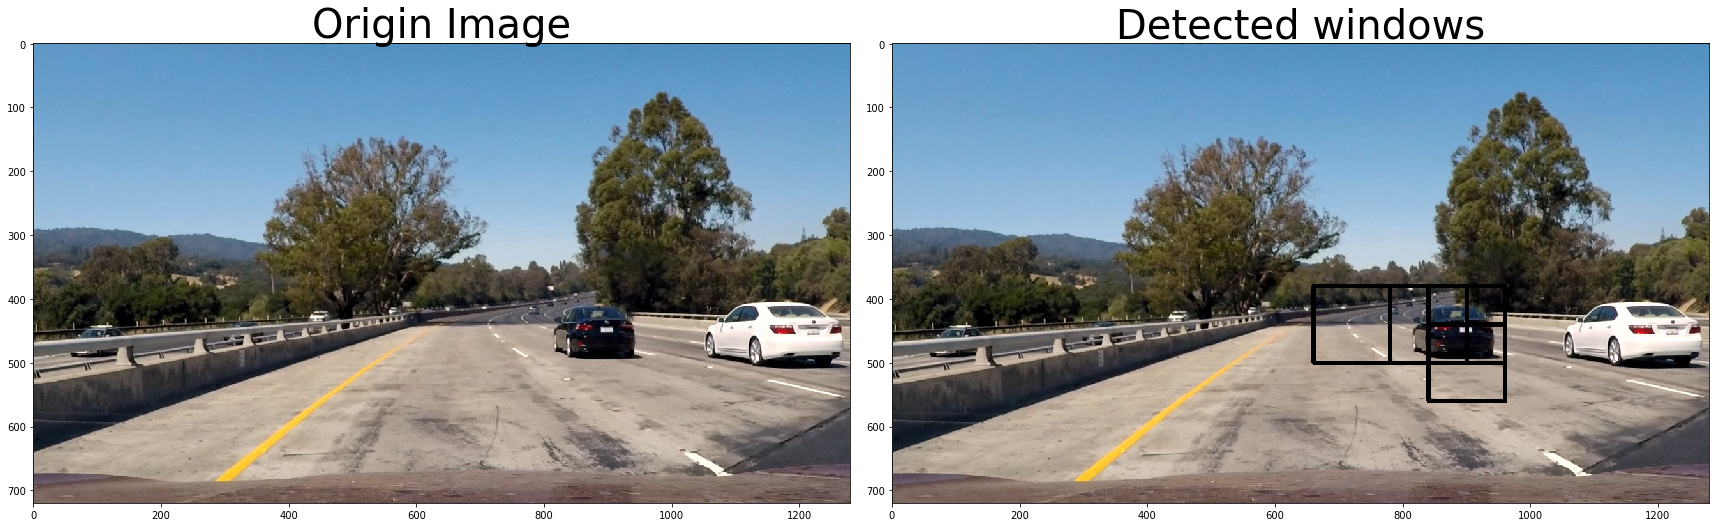

In [18]:
image = mpimg.imread('./test_images/test1.jpg')
image = image.astype(np.float32)/255
draw_image = np.copy(image)

t=time.time()
windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[320, 720], xy_window=(120, 120), xy_overlap=(0.5, 0.5))

detected_windows =  search_windows(image, windows, clf=svc, scaler=X_scaler, color_space=colorspace,
                                   spatial_size=(spatial, spatial), hist_bins=histbin, orient=orient,
                                   pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, hog_channel=hog_channel,
                                   spatial_feat=True, hist_feat=True, hog_feat=True)
t2 = time.time()
print(round(t2-t, 5), ' Seconds to search windows ...')

window_img = draw_boxes(draw_image, detected_windows, color=(0, 0, 255), thick=6)                    

plt.figure()
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Origin Image', fontsize=40)

ax2.imshow(window_img)
ax2.set_title('Detected windows', fontsize=40)

plt.show()

So we can see that the model can identify the car object like above. Now we should define multi scale slide windows and apply on image.

In [10]:
def search_multi_scales(image):
    
    hot_windows = []
    all_windows = []

    X_start_stop =[[None,None],[None,None],[None,None],[None,None]]
    w0,w1,w2,w3 = 240,180,120,70
    o0,o1,o2,o3 = 0.5,0.5,0.5,0.5
    XY_window = [(w0,w0), (w1,w1), (w2,w2), (w3,w3)]
    XY_overlap = [(o0,o0), (o1,o1), (o2,o2), (o3,o3)]              
    Y_start_stop =[[320, 720], [320, 720], [320, 720], [320, 720]]    
    
    for i in range(len(Y_start_stop)):
        windows = slide_window(image, x_start_stop=X_start_stop[i], y_start_stop=Y_start_stop[i], 
                            xy_window=XY_window[i], xy_overlap=XY_overlap[i])
        
        all_windows += [windows]        
        
        hot_windows +=  search_windows(image, windows, svc, X_scaler, color_space=colorspace, 
                            spatial_size=(spatial, spatial), hist_bins=histbin, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=True, 
                            hist_feat=True, hog_feat=True)                       

    return hot_windows,all_windows

2.08465  Seconds to search windows ...


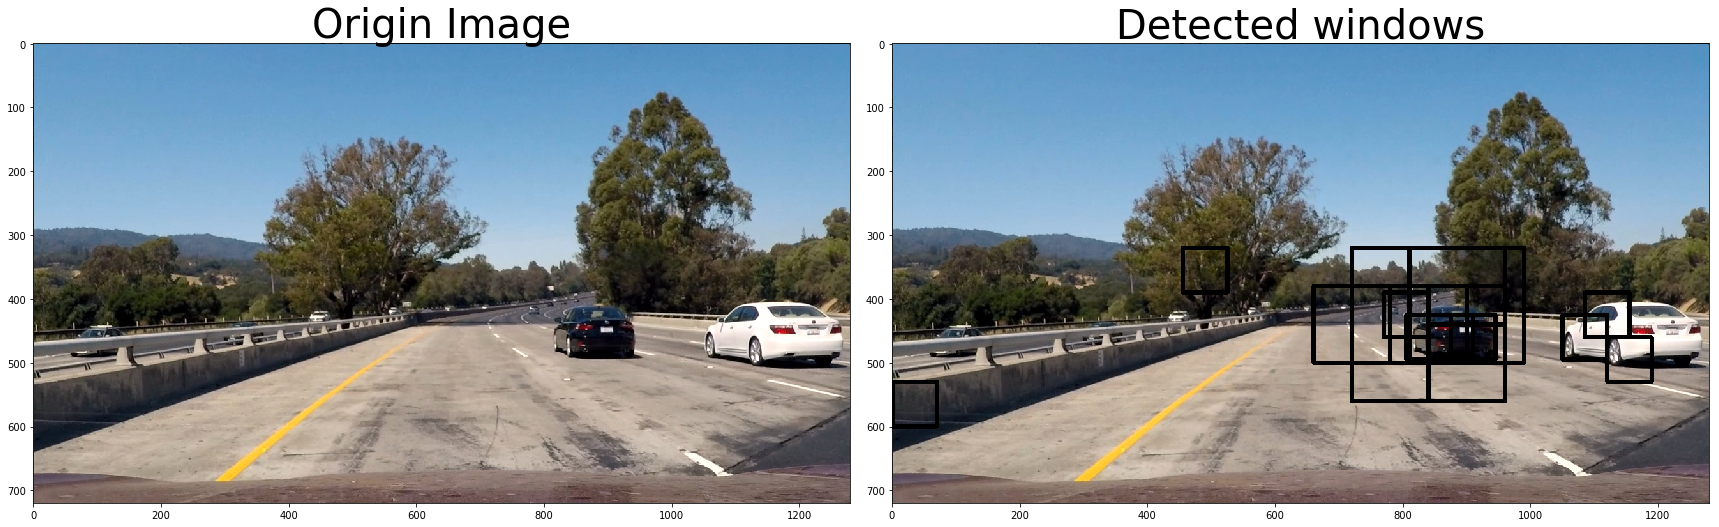

In [20]:
image = mpimg.imread('./test_images/test1.jpg')
image = image.astype(np.float32)/255
draw_image = np.copy(image)

t=time.time()
hot_windows, all_windows = search_multi_scales(image)
t2 = time.time()
print(round(t2-t, 5), ' Seconds to search windows ...')

window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)                    

plt.figure()
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(image)
ax1.set_title('Origin Image', fontsize=40)

ax2.imshow(window_img)
ax2.set_title('Detected windows', fontsize=40)

plt.show()

## Step 6: Multiple Detections and False Positives
We will apply the heatmap and labelizaion method which is used for handling the Multiple Detections and False Positives

In [11]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

2.05 Seconds to search windows ...


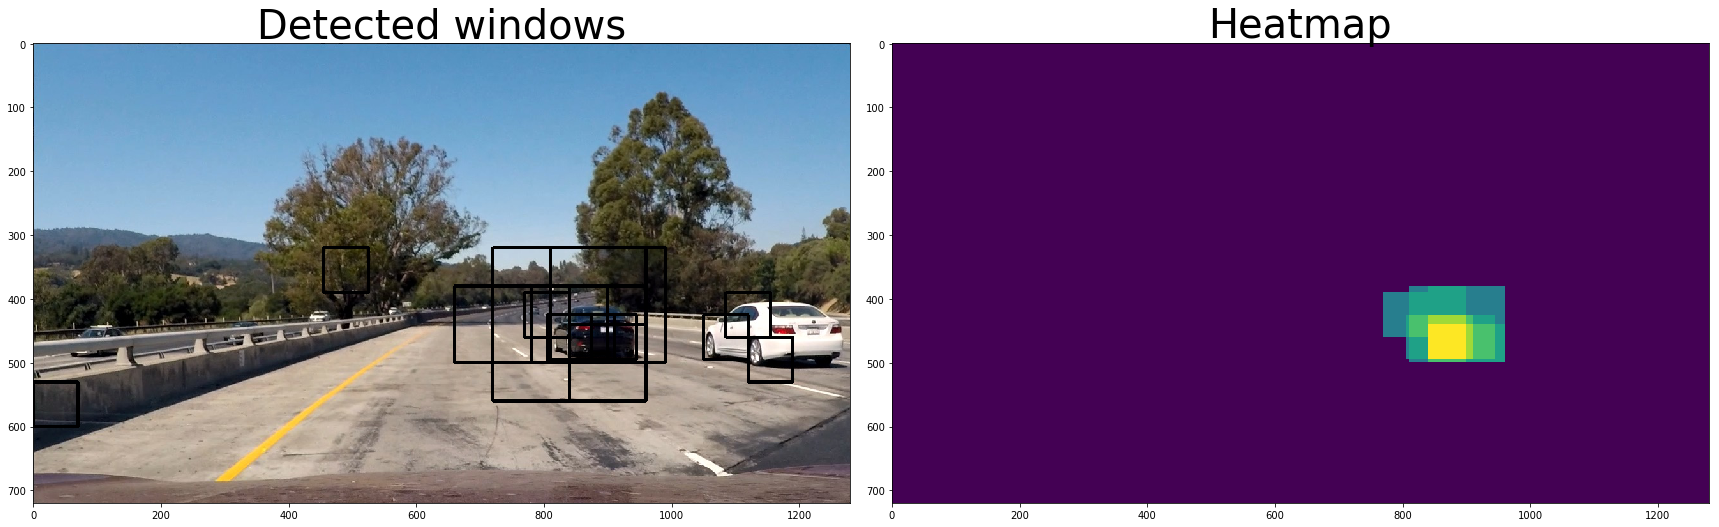

In [22]:
image = mpimg.imread('./test_images/test1.jpg')
image = image.astype(np.float32)/255
draw_image = np.copy(image)

t=time.time()
hot_windows, all_windows = search_multi_scales(image)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to search windows ...')
    
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=4)                    
    

# Read in the last image shown above 
heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
heatmap = add_heat(heatmap, hot_windows)
heatmap  = apply_threshold(heatmap,2)
    
plt.figure()    
# Plot the result
f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()

ax1.imshow(window_img)
ax1.set_title('Detected windows', fontsize=40)
    
ax2.imshow(heatmap)
ax2.set_title('Heatmap', fontsize=40)

plt.show()

## Step 7: Video Pipeline

In [12]:
class TrackBoxes:
    def __init__(self,n=10):
        self.n = n
        self.recent_boxes = deque([],maxlen=n)
        self.current_boxes = None
        self.allboxes = []

    def add_boxes(self):
        self.recent_boxes.appendleft(self.current_boxes)
        
    def pop_data(self):
        if self.n_buffered>0:
            self.recent_boxes.pop()
            
    def set_current_boxes(self,boxes):
        self.current_boxes = boxes
        
    def get_all_boxes(self):
        allboxes = []
        for boxes in self.recent_boxes:
            allboxes += boxes
        self.allboxes = allboxes
            
    def update(self,boxes):
        self.set_current_boxes(boxes)
        self.add_boxes()
        self.get_all_boxes()

In [13]:
boxes = TrackBoxes(n=30)

def process_image(image):
    draw_image = np.copy(image)
    image = image.astype(np.float32)/255
    hot_windows, _ = search_multi_scales(image)
    boxes.update(hot_windows)
    heatmap = np.zeros_like(image[:,:,0]).astype(np.float)
    heatmap = add_heat(heatmap, boxes.allboxes)
    heatmap = apply_threshold(heatmap,10)
    labels = label(heatmap)
    
    window_image = draw_labeled_bboxes(draw_image, labels)
    
    return window_image

In [26]:
clip = VideoFileClip('./test_video.mp4')
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile('./output_images/test_video_output.mp4', audio=False)

[MoviePy] >>>> Building video ./output_images/test_video_output.mp4
[MoviePy] Writing video ./output_images/test_video_output.mp4


 97%|█████████▋| 38/39 [01:04<00:01,  1.69s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/test_video_output.mp4 

CPU times: user 1min 3s, sys: 704 ms, total: 1min 3s
Wall time: 1min 4s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./output_images/test_video_output.mp4'))

In [ ]:
clip = VideoFileClip('./project_video.mp4')
out_clip = clip.fl_image(process_image) 
%time out_clip.write_videofile('./output_images/project_video_output.mp4', audio=False)

[MoviePy] >>>> Building video ./output_images/project_video_out.mp4
[MoviePy] Writing video ./output_images/project_video_out.mp4


 92%|█████████▏| 1155/1261 [36:44<03:34,  2.02s/it]

In [16]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format('./output_images/project_video_output.mp4'))